# 3 bars rising up or falling down - Analytics

### Import Library

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [2]:
import os
from pathlib import Path
notebook_path = os.getcwd()
current_dir = Path(notebook_path)
csv_file = str(current_dir) + '/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [3]:
data = dataset.copy()

In [4]:
data.tail(20)

,Open,High,Low,Close,Volume
Date,,,,,
2025-10-21 11:25:00,1868.6,1875.9,1865.0,1873.0,5958
2025-10-21 13:00:00,1873.6,1883.0,1873.0,1877.7,8695
2025-10-21 13:05:00,1877.8,1885.8,1877.8,1881.2,6718
2025-10-21 13:10:00,1881.4,1884.8,1878.3,1884.5,5454
2025-10-21 13:15:00,1884.5,1900.0,1884.5,1899.9,16683
2025-10-21 13:20:00,1899.9,1906.0,1892.6,1894.9,14956
2025-10-21 13:25:00,1894.9,1902.9,1889.2,1899.2,10721
2025-10-21 13:30:00,1899.2,1903.2,1892.0,1897.6,9370
2025-10-21 13:35:00,1898.0,1904.9,1896.4,1902.4,9267


In [5]:
data["color"] = data.apply(lambda r: "green" if r["Close"] > r["Open"] else ("red" if r["Close"] < r["Open"] else "doji"), axis=1)
data["color_shift1"] = data["color"].shift(1)
data["color_shift2"] = data["color"].shift(2)

In [6]:
data["is_3_white_soliders"] = data.apply(lambda r: "yes" if r["color"] == "green" and r["color_shift1"] == "green" and r["color_shift2"] == "green" else "", axis=1)
data["is_3_black_crows"] = data.apply(lambda r: "yes" if r["color"] == "red" and r["color_shift1"] == "red" and r["color_shift2"] == "red" else "", axis=1)

In [7]:
%%time
data['risk'] = None
data['reward'] = None
for i, row in data.iterrows():
    if row['is_3_white_soliders'] == "yes" or row['is_3_black_crows'] == "yes":
        current_date = row.name.strftime('%Y-%m-%d ').format()
        current_time = row.name
        entry_price = row['Close']
        data_to_end_day = data[(data.index > current_time) & (data.index < current_date+' 14:30:00')]
        max_price = entry_price
        min_price = entry_price
        for k, wrow in data_to_end_day.iterrows():
            if wrow['Low'] < min_price:
                min_price = wrow['Low']
            if wrow['High'] > max_price:
                max_price = wrow['High']
        if row['is_3_white_soliders'] == "yes":
            # Long
            risk = entry_price - min_price
            reward = max_price - entry_price
        else:
            # row['is_3_black_crows'] == "yes":
            # Short
            risk = max_price - entry_price
            reward = entry_price - min_price
        data.at[i, 'risk'] = risk
        data.at[i, 'reward'] = reward

CPU times: user 31.4 s, sys: 5.98 ms, total: 31.4 s
Wall time: 31.4 s


### Phân tích mối quan hệ Risk/Reward

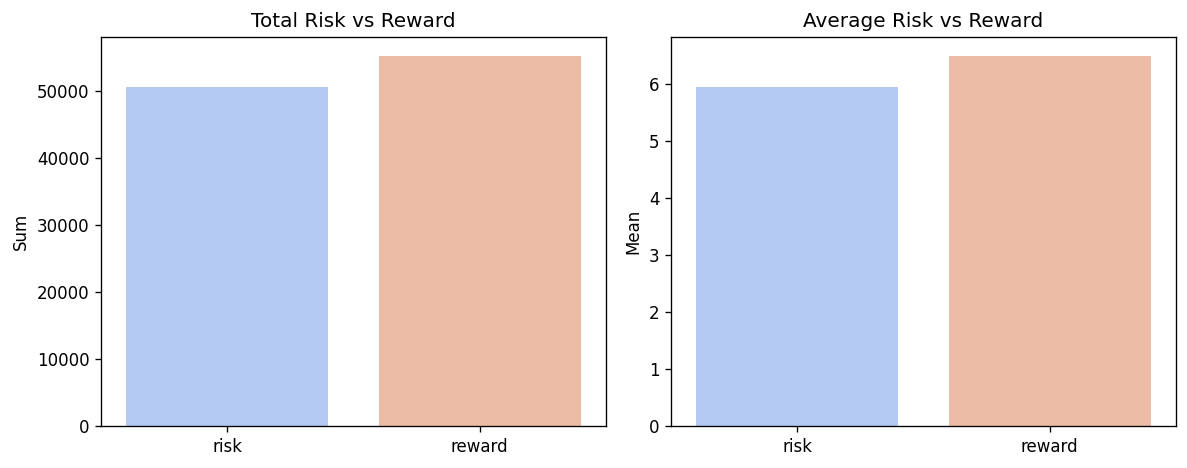

In [8]:
df2 = data[["Open", "Close", "High", "Low", "is_3_white_soliders", "is_3_black_crows", "risk", "reward"]].copy()
df2["risk"] = df2["risk"].astype(float)
df2["reward"] = df2["reward"].astype(float)
df2_fit = df2[df2.is_3_white_soliders=="yes"]
df2.dropna(inplace=True)
sum_df = df2_fit[["risk", "reward"]].sum().reset_index(name="value")
mean_df = df2_fit[["risk", "reward"]].mean().reset_index(name="value")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(data=sum_df, x="index", y="value", ax=axes[0], palette="coolwarm")
axes[0].set_title("Total Risk vs Reward")
axes[0].set_xlabel("")
axes[0].set_ylabel("Sum")

sns.barplot(data=mean_df, x="index", y="value", ax=axes[1], palette="coolwarm")
axes[1].set_title("Average Risk vs Reward")
axes[1].set_xlabel("")
axes[1].set_ylabel("Mean")

plt.tight_layout()
plt.show()

### Phân tích mối quan hệ Risk/Reward vs Time 9h

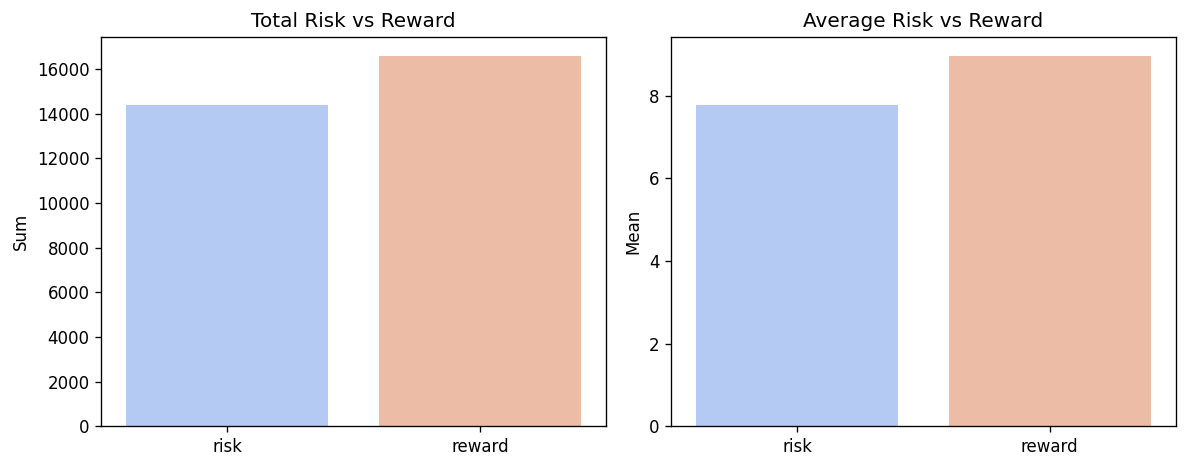

In [9]:
df3 = data[["Open", "Close", "High", "Low", "is_3_white_soliders", "risk", "reward"]].copy()
df3["risk"] = df3["risk"].astype(float)
df3["reward"] = df3["reward"].astype(float)
df3["hour"] = df3.index.hour
df3_fit = df3[(df3.is_3_white_soliders=="yes") & (df3.hour==9)]
df3.dropna(inplace=True)
sum_df = df3_fit[["risk", "reward"]].sum().reset_index(name="value")
mean_df = df3_fit[["risk", "reward"]].mean().reset_index(name="value")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(data=sum_df, x="index", y="value", ax=axes[0], palette="coolwarm")
axes[0].set_title("Total Risk vs Reward")
axes[0].set_xlabel("")
axes[0].set_ylabel("Sum")

sns.barplot(data=mean_df, x="index", y="value", ax=axes[1], palette="coolwarm")
axes[1].set_title("Average Risk vs Reward")
axes[1].set_xlabel("")
axes[1].set_ylabel("Mean")

plt.tight_layout()
plt.show()

## Phân tích mối quan hệ Risk/Reward và ATR & RSI

In [66]:
df1 = data[["Open", "Close", "High", "Low", "is_3_white_soliders", "is_3_black_crows", "risk", "reward"]].copy()
df1["risk"] = df1["risk"].astype(float)
df1["reward"] = df1["reward"].astype(float)
df1["return"] = df1["reward"] - df1["risk"]
df1["RSI_14"] = ta.rsi(df1["Close"], length=14)
df1["ATR_14"] = ta.atr(high=df1["High"], low=df1["Low"], close=df1["Close"], length=14)
df1.dropna(inplace=True)
df1["RSI_14"] = round(df1["RSI_14"], 1)
df1["ATR_14"] = round(df1["ATR_14"], 1)

In [67]:
df1['rsi_group'] = pd.qcut(df1.RSI_14, 20)
df1['atr_group'] = pd.qcut(df1.ATR_14, 20)

In [68]:
df1_long = df1[df1.is_3_white_soliders=="yes"]
long_risk = df1_long.groupby(['rsi_group', 'atr_group'])[['risk']]
long_reward = df1_long.groupby(['rsi_group', 'atr_group'])[['reward']]
long_return = df1_long.groupby(['rsi_group', 'atr_group'])[['return']]

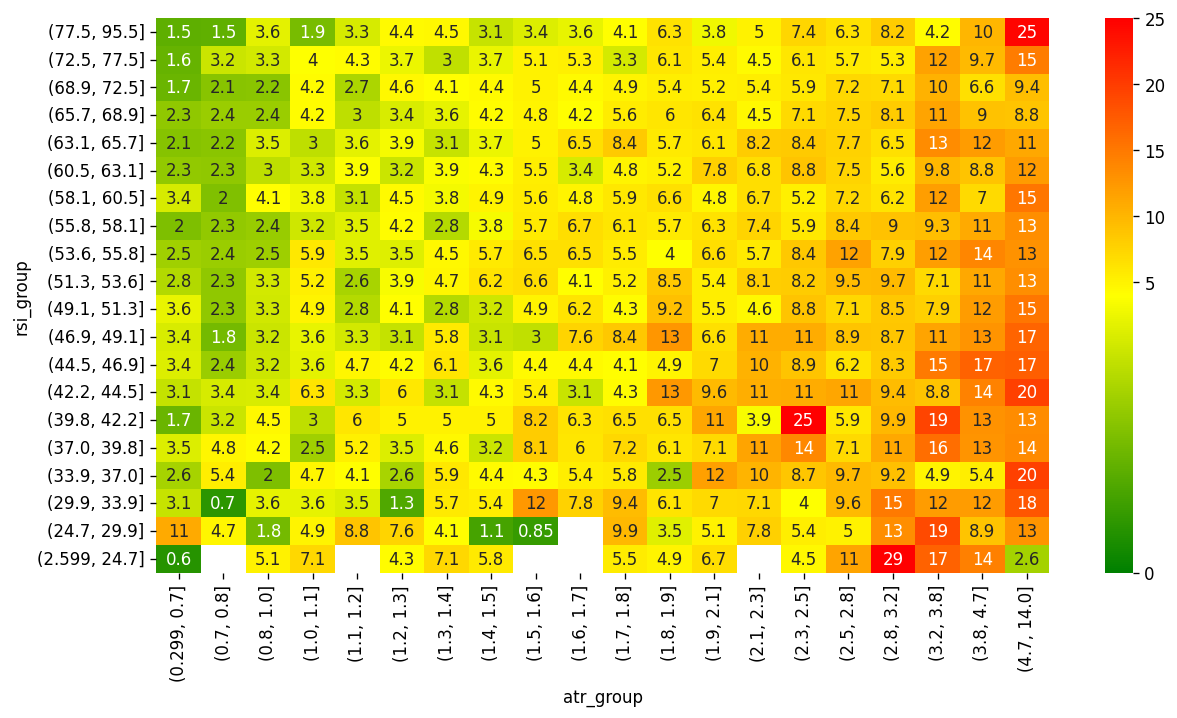

In [69]:
irs1 = long_risk.mean().reset_index()
irs_pivot1 = irs1.pivot(index='rsi_group', columns='atr_group', values='risk').sort_index(ascending=False)
sns.heatmap(
    irs_pivot1,
    cmap=LinearSegmentedColormap.from_list("green_to_red", ["green", "yellow", "red"]),
    norm=TwoSlopeNorm(vmin=0, vcenter=4, vmax=25),
    annot=True);

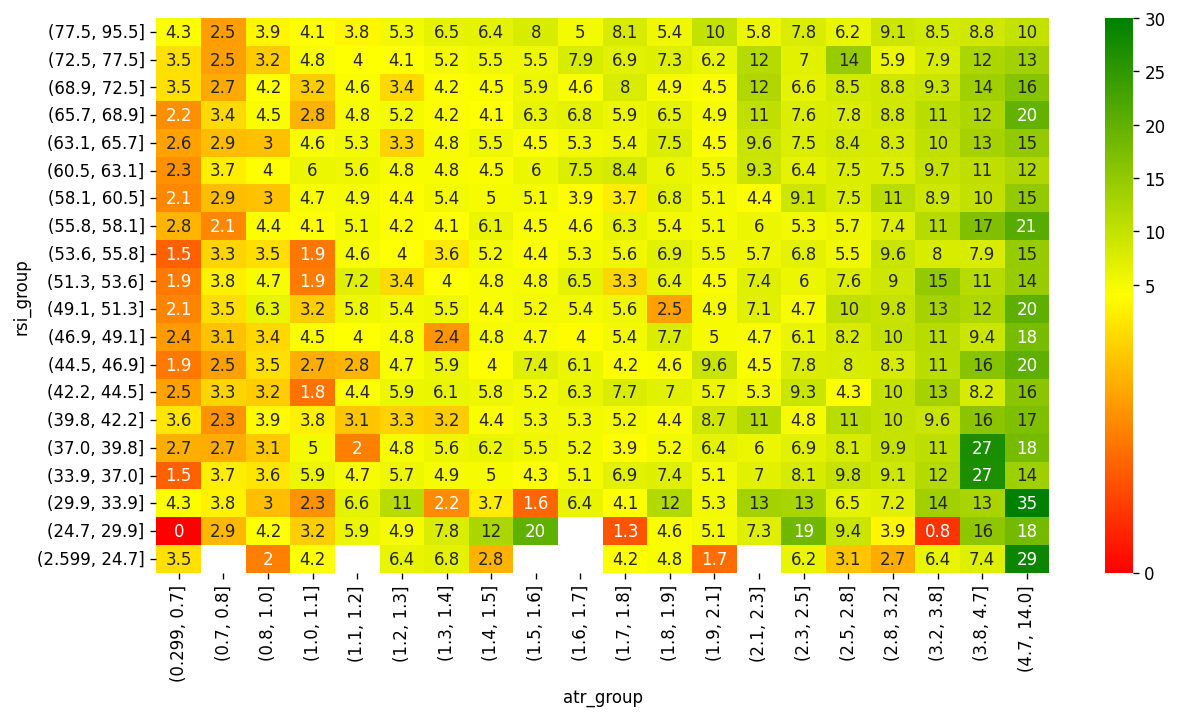

In [70]:
irs2 = long_reward.mean().reset_index()
irs_pivot2 = irs2.pivot(index='rsi_group', columns='atr_group', values='reward').sort_index(ascending=False)
sns.heatmap(
    irs_pivot2,
    cmap=LinearSegmentedColormap.from_list("red_to_green", ["red", "yellow", "green"]),
    norm=TwoSlopeNorm(vmin=0, vcenter=4, vmax=30),
    annot=True);

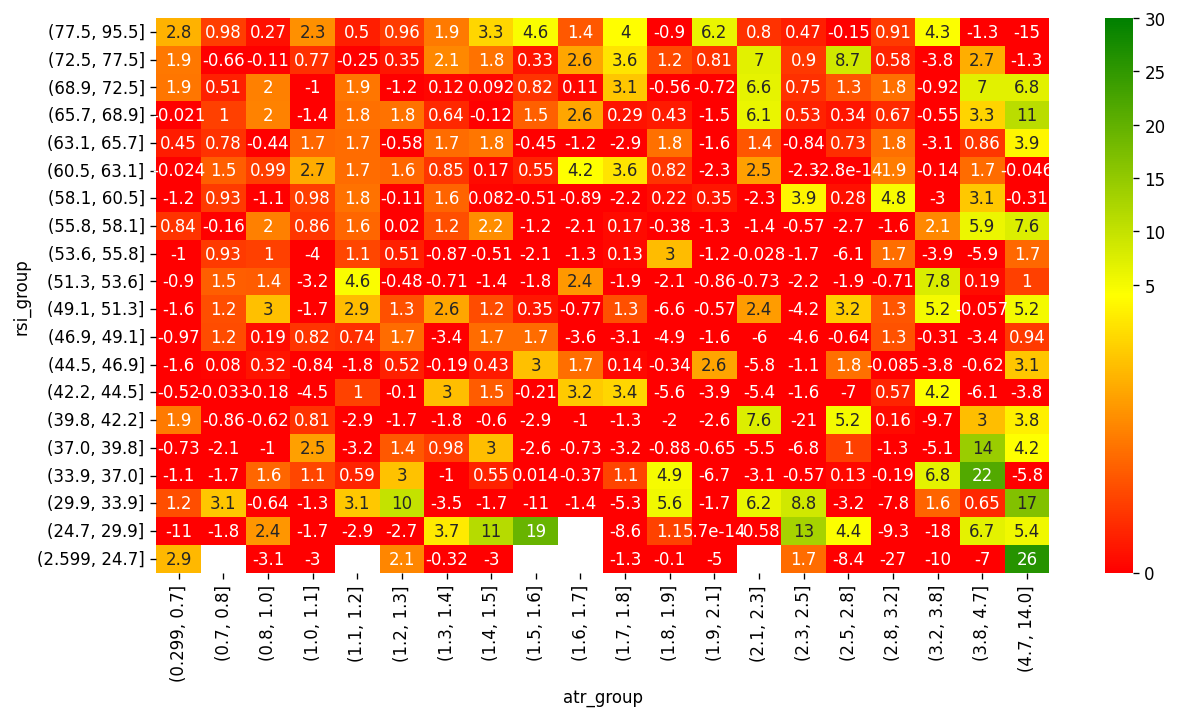

In [72]:
irs3 = long_return.mean().reset_index()
irs_pivot3 = irs3.pivot(index='rsi_group', columns='atr_group', values='return').sort_index(ascending=False)
sns.heatmap(
    irs_pivot3,
    cmap=LinearSegmentedColormap.from_list("red_to_green", ["red", "yellow", "green"]),
    norm=TwoSlopeNorm(vmin=0, vcenter=4, vmax=30),
    annot=True);

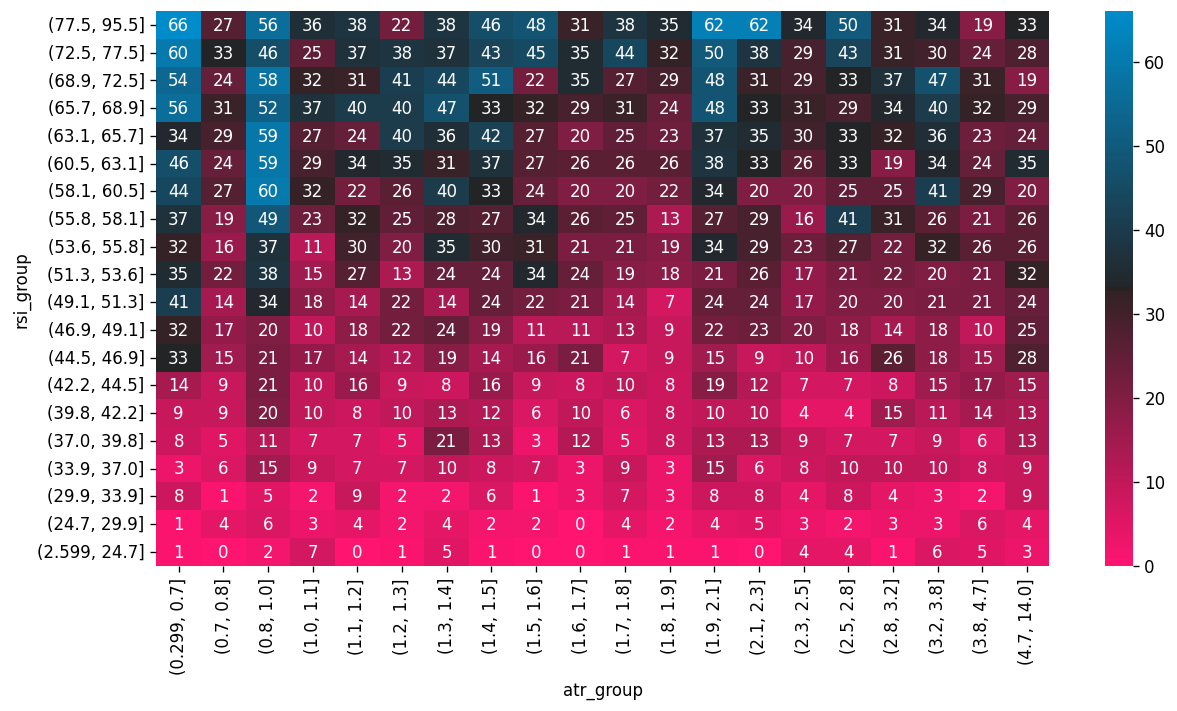

In [73]:
irs4 = long_return.count().reset_index()
irs_pivot4 = irs4.pivot(index='rsi_group', columns='atr_group', values='return').sort_index(ascending=False)
sns.heatmap(
    irs_pivot4,
    cmap=sns.diverging_palette(0, 240, s=100, l=55, center="dark", as_cmap=True),
    annot=True);

In [ ]:
# data["min_3"] = data["Low"].rolling(3).min()
# data["min_5"] = data["Low"].rolling(5).min()
# data["min_10"] = data["Low"].rolling(10).min()
# data["max_3"] = data["High"].rolling(3).max()
# data["max_5"] = data["High"].rolling(5).max()
# data["max_10"] = data["High"].rolling(10).max()

In [ ]:
# def cal_signal(row):
#     signal = ""
#     if row["is_3_white_soliders"] == "yes" and row["min_5"] == row["min_10"]:
#         signal = "long"
#     elif row["is_3_black_crows"] == "yes" and row["max_5"] == row["max_10"]:
#         signal = "short"
#     return signal

In [ ]:
# data["signal"] = data.apply(lambda r: cal_signal(r), axis=1)

In [ ]:
# data[data.signal != ""].tail(20)